In [1]:
import razor.flow as rf
import logging
import time, os
import typing as typ
import numpy as np
import pandas as pd
from razor import api

logger = logging.getLogger()


/usr/local/lib/python3.7/dist-packages/snowflake/connector/options.py:78: UserWarning: You have an incompatible version of 'pyarrow' installed (3.0.0), please install a version that adheres to: 'pyarrow<0.18.0,>=0.17.0; extra == "pandas"'
  warn_incompatible_dep('pyarrow', _installed_pyarrow_version.version, _expected_pyarrow_version)


In [2]:
def project_space_path(path):
    ps = api.datasources('Project Space')
    return os.path.join(ps.abspath(), path)


In [3]:
@rf.block
class STDIn:
    filename: str
    records: int
    out_ds: rf.SeriesOutput[typ.Any]

    def run(self):
        with open(project_space_path(self.filename), 'r') as f:
            text_str = f.read()

        logger.info(len(text_str))
        for _ in range(self.records):
            self.out_ds.put(text_str)


@rf.block
class STDOut:
    in_ds: rf.SeriesInput[typ.Any]
    out_filename: str

    def run(self):
        text_str = [str(i) for i in self.in_ds][0]
        logger.info(len(text_str))
        with open(project_space_path(self.out_filename), 'w') as f:
            f.write(text_str)
            

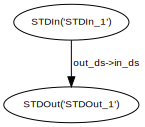

In [4]:
config = {'cores': 1, 'ram': 4096}
records = 100
size = '10MB'
ip_filename = project_space_path("sdk_testbench/input_data/file" + size + ".txt")
op_filename = project_space_path("sdk_testbench/output_data/tc_05.txt")

std_in = STDIn(records=records, filename=ip_filename)
# std_in.executor = rf.ContainerExecutor(cores=config['cores'], memory=config['ram'])
# std_in.out_ds = rf.Output.set(transport=rf.SocketTransport)

std_out = STDOut(in_ds=std_in.out_ds, out_filename=op_filename)
# std_out.executor = rf.ContainerExecutor(cores=config['cores'], memory=config['ram'])

pipeline = rf.Pipeline(name='series_kafka_transport', targets=[std_out])
pipeline


In [5]:
pipeline.execute()

<Process(Pipeline Manager('series_kafka_transport'), stopped)>